# Data Analysis using SQL - Chinook Database
In this project we will be performing business analysis using a relational database. Our databasehe Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers. You can find the original GitHub repository [here](https://github.com/lerocha/chinook-database). We will use come up with business strategies by using SQL queries to pull frequency tables and interpreting the data.

The information of the Chinook Database is contained in several tables, and these tables have primary and foreign keys that create relationships between them:

![Chinook Schema](https://s3.amazonaws.com/dq-content/189/chinook-schema.svg)
_Source:_ [_Dataquest.io_](https://www.dataquest.io)

## Running SQL Queries in Python
To pull the data from the Chinook database, we will be using the [SQLite3 library](https://www.sqlite.org/index.html). Below we will create helper functions to input queries and return tables in DataFrame format and run commands to make any modifications that do not require any table to be returned. In order to avoid any unwanted changes in our database, we will use a [context manager](https://docs.python.org/3/library/sqlite3.html#using-the-connection-as-a-context-manager) that opens and closes any connections any time we run a query.

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import sqlite3 # Relational database management
import pandas as pd # Data processing
import numpy as np # Linear algebra
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
sns.set_style('dark')

In [2]:
db = 'chinook.db'

def run_query(q): ###returns df table from query
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)
    
def run_command(c): ###sql query where we do not need to return table
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        return conn.execute(c)

def show_tables(): ###query to show all the tables in the database, uses run_query function defined before
    q = '''SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table","view");'''
    return run_query(q)

In [3]:
show_tables() 

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Sales Analysis
Our fictious company sells its product in various countries. If we wanted to invest in a marketing campaign and acquire new songs to expand our repertoire, we would need to create an effective business strategy in the first place. Our dataset contains very useful information about the customers and invoices, including country of residence/billing country.


To decide which countries will be the marketing target and which songs we should add to our stock, we will answer following questions:

1. Which countries have the greatest sales value? The countries with the greatest sales value will provide the highest sales potential.
2. What are the most popular genres? If we add new songs to our stock, we will want them to belong to the top purchased genres.

### Countries with Greatest Sale Value

In [4]:
sales_by_country='''
    WITH all_countries AS
    (
    SELECT 
        CASE 
            WHEN COUNT(DISTINCT i.customer_id) = 1 THEN 'Others'
            ELSE c.country
        END AS country,
        COUNT(DISTINCT i.customer_id) total_customers,
        SUM(i.total) total_sales,
        SUM(i.total) / COUNT(DISTINCT c.customer_id) avg_sales_customer,
        AVG(i.total) avg_order_value
    FROM customer c
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY c.country
    )
    
    SELECT
        country,
        SUM(total_customers) total_customers,
        SUM(total_sales) total_sales,
        ROUND(AVG(avg_sales_customer),2) avg_sales_customer,
        ROUND(AVG(avg_order_value),2) avg_order_value
    FROM 
        (
        SELECT
            *,
            CASE
                WHEN country = 'Others' THEN 1
                ELSE 0
            END AS sort
            FROM all_countries
        )
    GROUP BY country
    ORDER BY sort, total_sales DESC
'''


sales_by_country_df = run_query(sales_by_country)
sales_by_country_df

,country,total_customers,total_sales,avg_sales_customer,avg_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.65,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.56,6.38
8,India,2,183.15,91.57,8.72
9,Others,15,1094.94,73.00,7.45


In [5]:
sales_by_country_df = sales_by_country_df.sort_values(by='total_sales')
sales_by_country_df.set_index('country',inplace=True,drop=True)

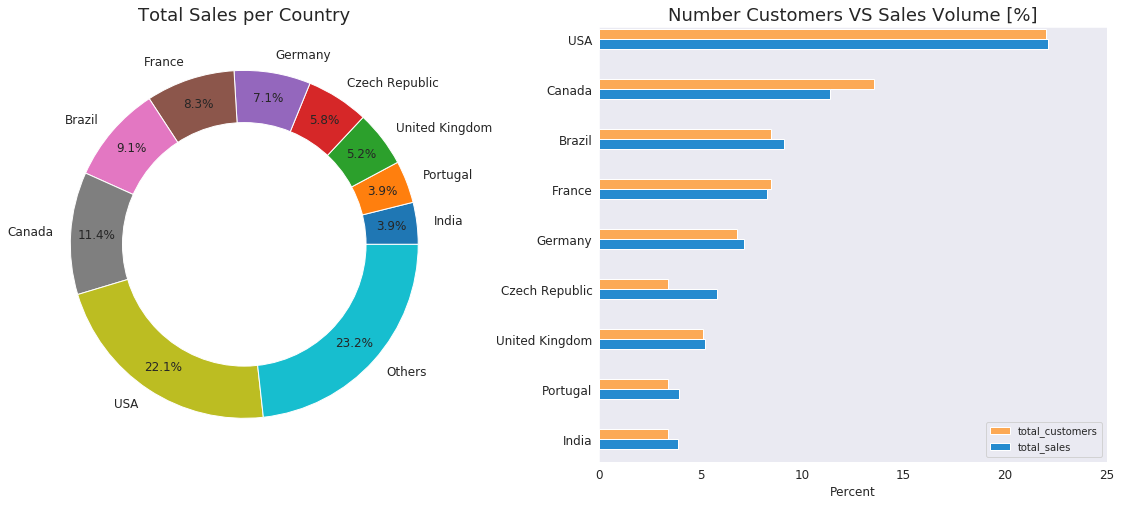

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax1, ax2 = axes.flatten() # Easier to work with the axes this way instead of coordinates

### Pie plot - sales per country 
sales_by_country_df['total_sales'].plot.pie(
    title='Total Sales per Country',
    ax=ax1,
    startangle=0,
    autopct='%1.1f%%', # returns percentage values
    fontsize=12,
    pctdistance=0.85 # percent label position
)

ax1.set_ylabel('')

# Aesthetics: Draw circle on pie --> donut chart
centre_circle = plt.Circle((0,0),0.7,fc='white')
ax1.add_patch(centre_circle)
ax1.title.set_size(18)

### Horizontal bar plot - compare customers vs sales volume in percentages
colors = ['#FCA955','#258BCF'] # 2 defined colors for horizontal bar plot

for i in range(0,2):
    pct_values = 100 * sales_by_country_df.iloc[:,i]/sales_by_country_df.iloc[:,i].sum() #calculate pct values for each total_customers and total_sales
    pct_values[:-1].plot.barh( # Not showing Others, top countries shown
    y=sales_by_country_df.columns[i],
    ax=ax2,
    legend=False,
    position=i,
    color=colors[i],
    width=.2, #bar width
    fontsize=12,
    xlim=(0,25) #max xlim 25 pct
    )
    
ax2.set_ylabel('')
ax2.set_xlabel('Percent', fontsize=12)
ax2.set_title('Number Customers VS Sales Volume [%]')
ax2.legend()
ax2.title.set_size(18)
plt.show()

### Top Genres in the USA
As we can see in our previous analysis, the USA have the greatest sales volume and number of customers, whose value doubles the amount generated by selling our product to Canadian customers. This answers our first question. Now we know that our business strategy should be directed to the American market, since we can predict a geater potential for a higher sales volume and capturing new customers.

In order to determine what songs to invest in, we will answer our second question: What are the most popular genres in the USA? This will help us narrow down what type of songs we should add to our stock.

In [7]:
sold_tracks_USA = """
    WITH tracks_usa AS
        (
        SELECT 
            il.invoice_id,
            i.billing_country country,
            g.name genre
        FROM invoice_line il
        LEFT JOIN invoice i ON il.invoice_id = i.invoice_id
        LEFT JOIN track t ON il.track_id = t.track_id
        LEFT JOIN genre g ON t.genre_id = g.genre_id
        WHERE COUNTRY = 'USA'
        )

    SELECT
        tu.genre,
        COUNT(*) genre_sales,
        ROUND(100 * CAST(COUNT(*) AS FLOAT)/(SELECT CAST(COUNT(*) AS FLOAT) FROM tracks_usa),2) genre_sales_pct

    FROM tracks_usa tu

    GROUP BY tu.genre
    ORDER BY genre_sales DESC
    LIMIT 10
"""

sold_tracks_USA_df = run_query(sold_tracks_USA)
sold_tracks_USA_df

,genre,genre_sales,genre_sales_pct
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


In [8]:
sold_tracks_USA_df = sold_tracks_USA_df.sort_values(by='genre_sales')
sold_tracks_USA_df.set_index('genre',inplace=True,drop=True)

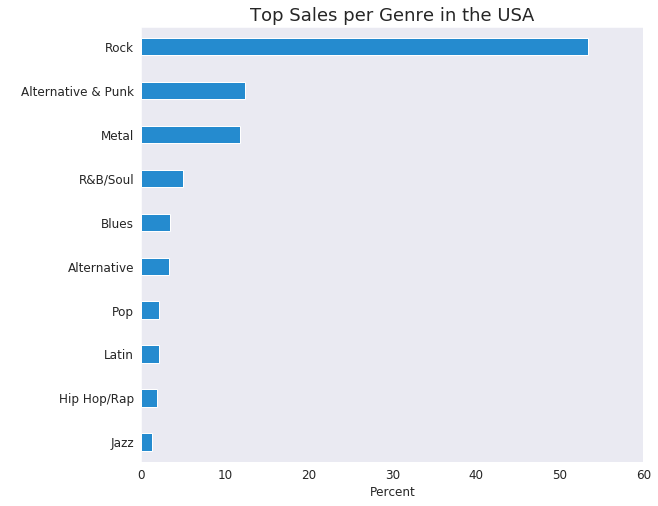

In [9]:
sold_tracks_USA_df.plot.barh(
    y='genre_sales_pct',
    color=colors[1],
    xlim=(0,60),
    legend=False,
    figsize=(9,8),
    width=.4,
    fontsize=12
    )
plt.title('Top Sales per Genre in the USA',fontsize=18)
plt.ylabel(' ')
plt.xlabel('Percent',fontsize=12)
plt.show()

Our previous bar plot shows how Rock is by far the most popular genre in our target market. If we decide to invest in new albums, Rock would be the genre with more potential, considering that we are adding popular songs.

## Employee Performance
Each customer is assigned to a sales representative. If we want to evaluate the performance of our sales representatives, we can determine the total sales volume generated by their assigned customers.

In [10]:
sales_employee = '''
    SELECT
        e.first_name || ' ' || e.last_name employee_name,
        e.title,
        e.hire_date,
        SUM(i.total) total_sales
    FROM employee e
    
    LEFT JOIN customer c ON e.employee_id = c.support_rep_id
    LEFT JOIN invoice i ON c.customer_id = i.customer_id
    
    WHERE title = 'Sales Support Agent'
    GROUP BY 1
    ORDER BY total_sales DESC

'''

sales_employee_df = run_query(sales_employee)
sales_employee_df

,employee_name,title,hire_date,total_sales
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


In [11]:
sales_employee_df=sales_employee_df.sort_values(by='total_sales')

sales_employee_df.set_index('employee_name',inplace=True,drop=True)

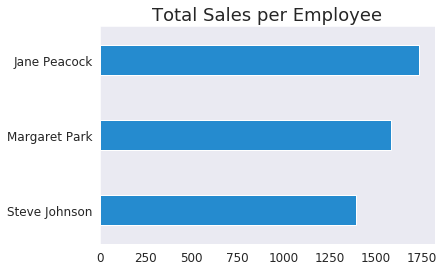

In [12]:
sales_employee_df.plot.barh(
    y='total_sales',
    color=colors[1],
    legend=False,
    width=.4,
    fontsize=12
    )

plt.title('Total Sales per Employee',fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.show()

In the bar plot shown above, we can see how all three sales support agents have generated a fairly similar volume of sales. Even though Steve Johnson has the lowest total sales amount, he was hired 5-6 months after M. Park and J. Peacock. 
Considering that no employee has left the company and that they have had a similar schedule/time off, Steve Johnson seems to be performing higher than the two older sales support agents.

In order to establish a valid employee performance analysis, we would need to estimate the amount of time that the employees have been working for the company to determine a value/time ratio -i.e. USD/hr invested in sales.